In [1]:
import pandas as pd
import numpy as np
from utilities.gex_parser import parse_gex_file
import matplotlib.pyplot as plt

from SimPEG.electromagnetics import time_domain as tdem

In [2]:
data_file = pd.read_csv('../data/MCWD3_dat.xyz')
data_file
data_file[data_file==9999] = np.NaN
gex_file = parse_gex_file('../data/20170606_337m2_Cal_DualWaveform_60Hz_414_412_418.gex')

In [3]:
gex_file

{'General': {'Description': 'Test geometry file',
  'GPSDifferentialPosition1': array([11.68,  2.79, -0.16]),
  'GPSPosition1': array([11.68,  2.79, -0.16]),
  'GPSPosition2': array([10.51,  3.95, -0.16]),
  'AltimeterPosition1': array([12.94,  1.79, -0.12]),
  'AltimeterPosition2': array([12.94, -1.79, -0.12]),
  'InclinometerPosition1': array([12.79,  1.64, -0.12]),
  'InclinometerPosition2': array([12.79,  1.64, -0.12]),
  'RxCoilPosition1': array([-13.25,   0.  ,  -2.  ]),
  'LoopType': 72,
  'FrontGateDelay': 2.5e-06,
  'TxLoopArea': 337.04,
  'NumberOfTurnsLM': 1,
  'NumberOfTurnsHM': 4,
  'RxCoilLPFilter1': array([9.9e-01, 2.1e+05]),
  'TxLoopPoints': array([[-12.64,  -2.13],
         [ -6.15,  -8.59],
         [  5.74,  -8.59],
         [ 11.13,  -3.19],
         [ 11.13,   3.19],
         [  5.74,   8.59],
         [ -6.15,   8.59],
         [-12.64,   2.13]]),
  'Waveforms': {'HM': {'time': array([-3.22220e-02, -3.17433e-02, -3.11906e-02, -3.04936e-02,
           -2.96885e-02

In [4]:
n_lm_gates = gex_file['Channel1']['NoGates'] - gex_file['Channel1']['RemoveInitialGates']
n_hm_gates = gex_file['Channel2']['NoGates'] - gex_file['Channel2']['RemoveInitialGates']

In [5]:
line_no = 206301
line_grouping = data_file.groupby('LINE_NO')
line = line_grouping.get_group(line_no)

In [6]:
lm_data = line.iloc[:, 9:9+n_lm_gates]
lm_std = line.iloc[:, 9+n_lm_gates:9+2*n_lm_gates]
hm_data = line.iloc[:, 9+2*n_lm_gates:9+2*n_lm_gates + n_hm_gates]
hm_std = line.iloc[:,  9+2*n_lm_gates + n_hm_gates:]

In [7]:
# select a single sounding along that line
# Record 5590
station = line[line.RECORD==5590]
station_lm_data = station.iloc[0, 9:9+n_lm_gates]
station_lm_std = station.iloc[0, 9+n_lm_gates:9+2*n_lm_gates]
station_hm_data = station.iloc[0, 9+2*n_lm_gates:9+2*n_lm_gates + n_hm_gates]
station_lm_std = station.iloc[0,  9+2*n_lm_gates + n_hm_gates:]

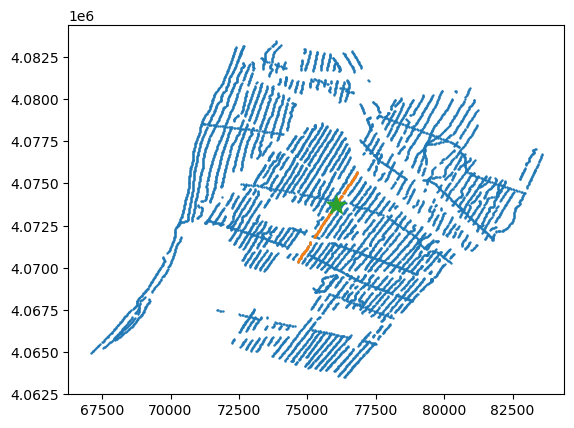

In [8]:
plt.scatter(data_file.UTMX, data_file.UTMY, s=0.5)
plt.scatter(line.UTMX, line.UTMY, s=0.5)
plt.scatter(station.UTMX, station.UTMY, s=200, marker='*')

Text(0.5, 0, 'Northing')

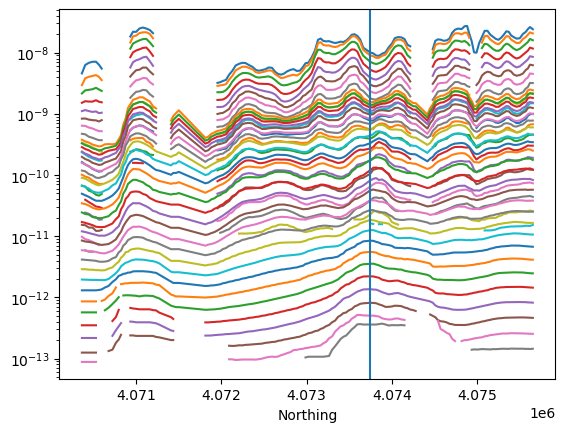

In [9]:
plt.semilogy(line.UTMY, lm_data);
plt.semilogy(line.UTMY, hm_data);
plt.axvline(station.UTMY.iloc[0]);
plt.xlabel('Northing')

In [10]:
gate_centers = gex_file['General']['GateTimes']['center']

channel_info = gex_file['Channel1']
shift = channel_info['GateTimeShift']
delay = channel_info['MeaTimeDelay']
first_gate = channel_info['RemoveInitialGates']
last_gate = channel_info['NoGates']
lm_times = gate_centers[first_gate:last_gate] + shift + delay

channel_info = gex_file['Channel2']
shift = channel_info['GateTimeShift']
delay = channel_info['MeaTimeDelay']
first_gate = channel_info['RemoveInitialGates']
last_gate = channel_info['NoGates']
hm_times = gate_centers[first_gate:last_gate] + shift + delay

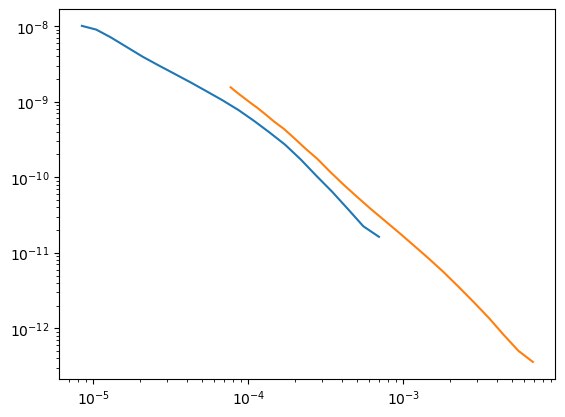

In [11]:
plt.loglog(lm_times, station_lm_data)
plt.loglog(hm_times, station_hm_data)

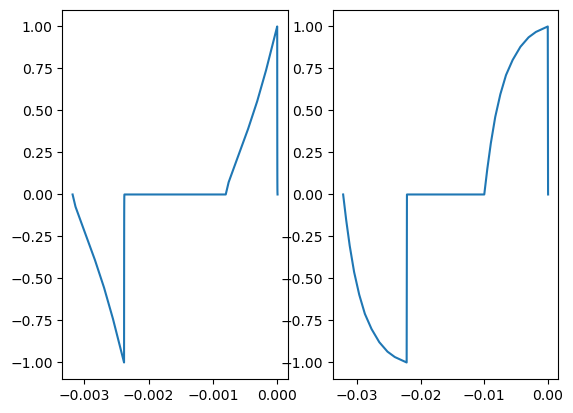

In [12]:
waves = gex_file['General']['Waveforms']
lm_wave_time = waves['LM']['time']
lm_wave_form = waves['LM']['form']
hm_wave_time = waves['HM']['time']
hm_wave_form = waves['HM']['form']
plt.subplot(121)
plt.plot(lm_wave_time, lm_wave_form)
plt.subplot(122)
plt.plot(hm_wave_time, hm_wave_form)

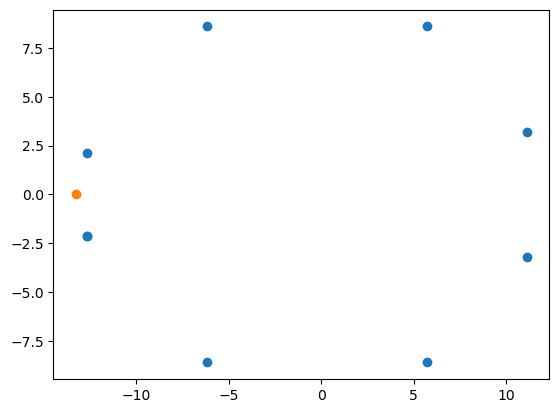

In [13]:
tx_shape = np.pad(gex_file['General']['TxLoopPoints'], (0, 1))
tx_shape[-1] = tx_shape[0]
rx_offset = gex_file['General']['RxCoilPosition1']
plt.scatter(*tx_shape[:, :-1].T)
plt.scatter(*rx_offset[:-1])

In [14]:
tx_loc = tx_shape + [station.UTMX.iloc[0], station.UTMY.iloc[0], station.INVALT.iloc[0]]
rx_loc = rx_offset + [station.UTMX.iloc[0], station.UTMY.iloc[0], station.INVALT.iloc[0]]

# Low moment:
rx_lm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, lm_times, orientation='z'
)

lm_wave = tdem.sources.PiecewiseLinearWaveform(lm_wave_time, lm_wave_form)

src_lm = tdem.sources.LineCurrent(rx_lm, tx_loc, waveform=lm_wave)

# high moment
rx_hm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, hm_times, orientation='z'
)

hm_wave = tdem.sources.PiecewiseLinearWaveform(hm_wave_time, hm_wave_form)

src_hm = tdem.sources.LineCurrent(rx_hm, tx_loc, waveform=hm_wave)

# combine them together into a single survey

srv = tdem.Survey([src_lm, src_hm])

In [15]:
#first a simple test
thicknesses = []
conductivities = [1E-2]

In [16]:
tx_area = gex_file['General']['TxLoopArea']

In [17]:
sim = tdem.Simulation1DLayered(srv, sigma=conductivities, thicknesses=thicknesses)

In [19]:
sim.thicknesses = [10, 15]
sim.sigma = [1E-1, 5E-1, 2E-1]
pre = -sim.dpred(None)
pre_lm = pre[:n_lm_gates]
pre_hm = pre[n_lm_gates:]

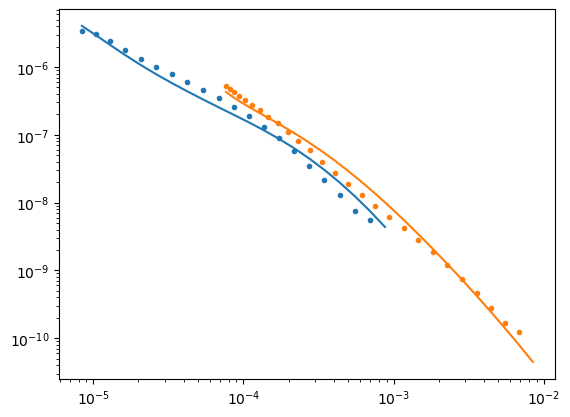

In [20]:
plt.loglog(lm_times, pre_lm)
plt.loglog(hm_times, pre_hm)
plt.loglog(lm_times, station_lm_data*tx_area, color='C0', marker='.', linestyle='')
plt.loglog(hm_times, station_hm_data*tx_area, color='C1', marker='.', linestyle='')